# Load Libraries

In [1]:
import os
from spectral import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import reciprocal
import pkg_resources
import sklearn
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import tqdm # nice progress bar
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load Data

In [3]:
# Load the quality-checked spectra and metadata from numpy variables
spectra = np.load('data/spectra.npy')
name = np.load('data/name.npy')# the genus and species if known, otherwise the common name (or material name for soil, road, etc.)

nSpec = spectra.shape[0]
nBands = spectra.shape[1]

X = spectra
Yn = name

Y_type = Yn
Y_labels = np.unique(Y_type)
nClasses = len(Y_labels)
Y = np.zeros(nSpec, dtype=int)
for i in range(nSpec):
    Y[i] = np.where(Y_labels == Y_type[i])[0]


print(f'Number of Spectra: {nSpec}')
print(f'Number of Bands: {nBands}')
print(X.shape,Y.shape)
print(f'Number of names: {len(np.unique(Yn))}: {np.unique(Yn)}\n')

Number of Spectra: 902
Number of Bands: 2151
(902, 2151) (902,)
Number of names: 18: ['Ammophila_breviligulata' 'Baccharis_halimifolia'
 'Chamaecrista_fasciculata' 'Chasmanthium_latifolium' 'Ilex_vomitoria'
 'Iva_frutescens' 'Panicum_amarum' 'Panicum_virgatum' 'Rosa_rugosa'
 'Solidago_sempervirens' 'clay' 'golf-course-sand' 'grass' 'iris'
 'milkweed' 'pasturegrass' 'soybean' 'timothy']



# Plots

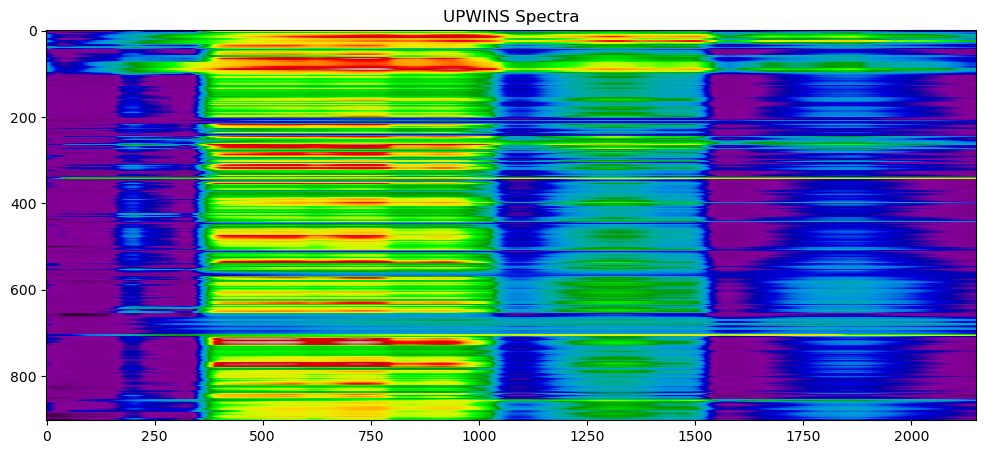

In [7]:
# Plot
fig = plt.figure(figsize = (12, 10))
plt.imshow(spectra, cmap = 'nipy_spectral')
plt.title('UPWINS Spectra')
plt.savefig('output/upwins_spectra.png') 
plt.show()

# 80/20 Split

In [133]:
# Create a test-train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)#, stratify=Y) # 80% of the data in the test set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])

(721, 2151) 0.7993348115299335
(181, 2151) 0.2006651884700665


### Lazzy Classifier

### LDA

In [137]:
# Compute the common mean for LDA
nbands = X_train.shape[1] #X_train
nspec = X_test.shape[0] #X_test

nClasses = len(np.unique(Y))
class_means = np.zeros((nClasses, nbands))
class_covariances = np.zeros((nClasses, nbands, nbands))
C = np.zeros((nbands,nbands))

class_indices = np.unique(Y_train).astype(int) #Y_train
for idx in class_indices:
    class_locations = np.where(Y_train==idx)[0] #Y_train
    num_class_spectra = len(class_locations)
    class_spectra = X_train[class_locations,:] #X_train
    class_means[idx,:] = np.mean(class_spectra, axis=0)
    class_covariances[idx,:,:] = np.cov(class_spectra.T) 
    C = C + num_class_spectra*class_covariances[idx,:,:]

num_labeled_spectra = np.sum(Y_train) #Y_train
C = C/num_labeled_spectra

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)


### Predict
WimList = np.matmul(W.T, X_test.T).T
 
# Compute Mahalanobis Distance to mean for each class, for all pixels
MD_all = np.zeros((nspec, nClasses))
for class_idx in range(nClasses):    
    # demean each pixel
    mu = class_means[class_idx,:]
    # whiten the mean
    Wmu = np.matmul(W.T, mu).T
    # subtract whitened mean from whitened data
    WimList_demean = WimList-Wmu
    # compute Mahalanobis Distance
    MDs = np.sum(WimList_demean**2, axis=1)
    MD = np.sqrt(MDs)
    # classify by minimum Mahalanobis distance
    MD_all[:,class_idx] = MD

LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (nspec))

### Evaluate LDA

Accuracy: 0.10497237569060773
Balanced Accuracy: 0.17223905723905725
F1 Score: 0.09863580387153505


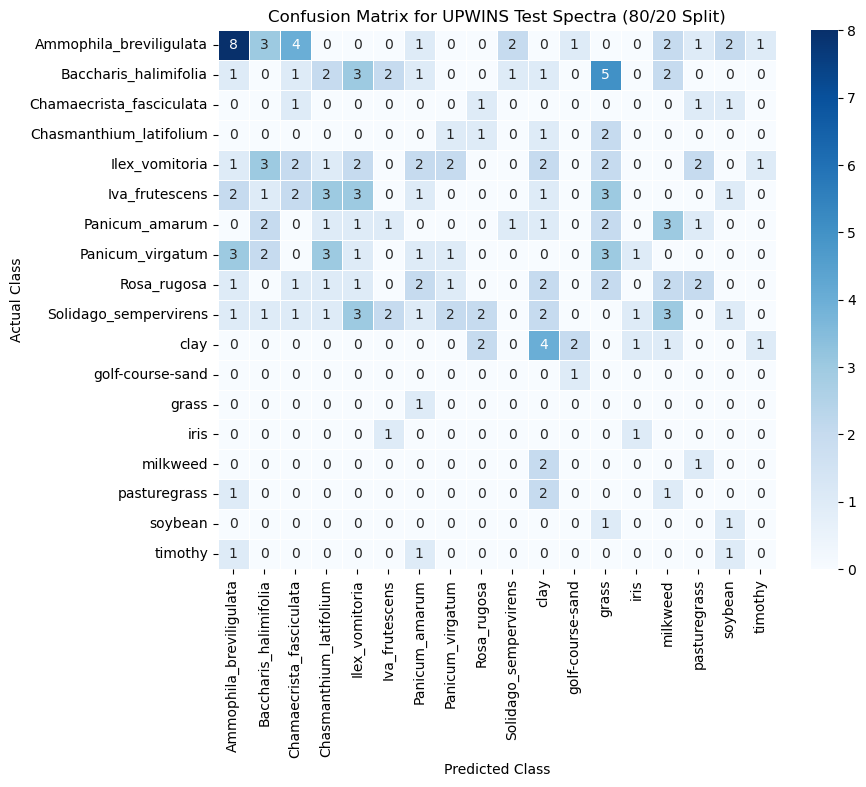

In [139]:
class_names = np.unique(Yn)
#import tensorflow as tf

y_true = Y_test
y_pred = LDA_class_list

#Metrics
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
bal = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {bal}')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

#Confusion Matrix
def plot_confusion_matrix(actual, predicted, labels):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for UPWINS Test Spectra (80/20 Split)')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(y_true, y_pred, class_names)
plt.savefig('output/upwins_80_20_confusionMatrix.png')

# 60/40 Split

In [150]:
# Create a test-train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y) # 60% of the data in the test set
print(X_train.shape,Y_train.shape[0] / Y.shape[0])
print(X_test.shape,Y_test.shape[0] / Y.shape[0])

(541, 2151) 0.5997782705099778
(361, 2151) 0.40022172949002216


### Lazy Classifier

### LDA

In [154]:
# Compute the common mean for LDA
nbands = X_train.shape[1] #X_train
nspec = X_test.shape[0] #X_test

nClasses = len(np.unique(Yn))
class_means = np.zeros((nClasses, nbands))
class_covariances = np.zeros((nClasses, nbands, nbands))
class_means = np.zeros((nClasses, nbands))
C = np.zeros((nbands,nbands))

class_indices = np.unique(Y_train).astype(int) #Y_train
for idx in class_indices:
    class_locations = np.where(Y_train==idx)[0] #Y_train
    num_class_spectra = len(class_locations)
    class_spectra = X_train[class_locations,:] #X_train
    class_means[idx,:] = np.mean(class_spectra, axis=0)
    class_covariances[idx,:,:] = np.cov(class_spectra.T) 
    C = C + num_class_spectra*class_covariances[idx,:,:]

num_labeled_spectra = np.sum(Y_train) #Y_train
C = C/num_labeled_spectra

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

WimList = np.matmul(W.T, X_test.T).T
 
# Compute Mahalanobis Distance to mean for each class, for all pixels
MD_all = np.zeros((nspec, nClasses))
for class_idx in range(nClasses):    
    # demean each pixel
    mu = class_means[class_idx,:]
    # whiten the mean
    Wmu = np.matmul(W.T, mu).T
    # subtract whitened mean from whitened data
    WimList_demean = WimList-Wmu
    # compute Mahalanobis Distance
    MDs = np.sum(WimList_demean**2, axis=1)
    MD = np.sqrt(MDs)
    # classify by minimum Mahalanobis distance
    MD_all[:,class_idx] = MD

LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (nspec))

### Evaluate LDA

Accuracy: 0.1634349030470914
Balanced Accuracy: 0.21263773351863094
F1 Score: 0.17579673057924602


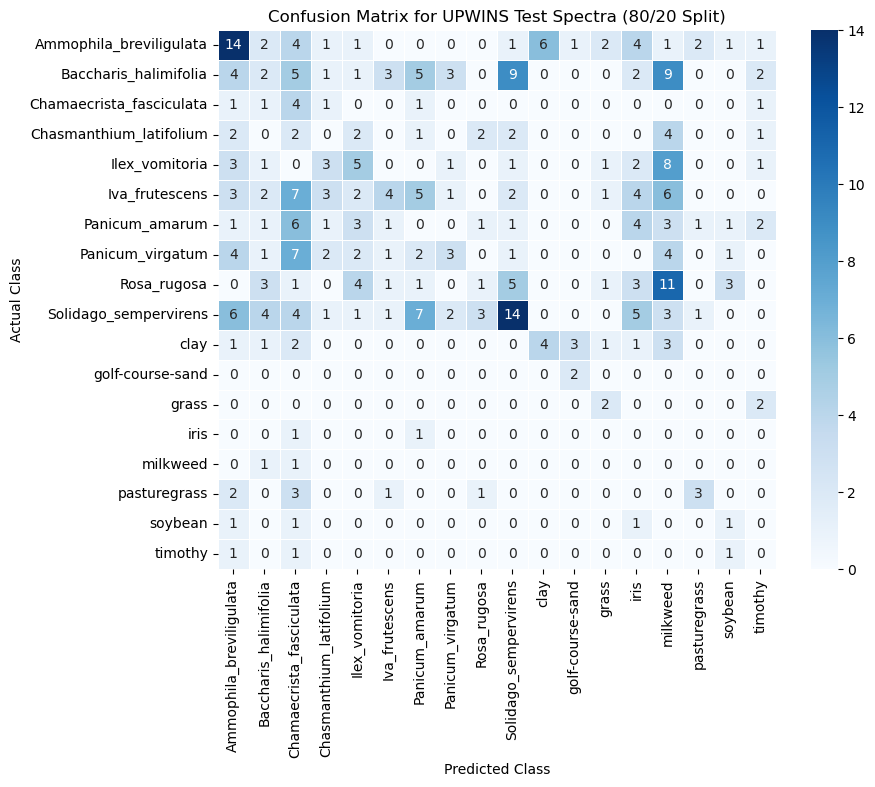

In [156]:
class_names = np.unique(Yn)

y_true = Y_test
y_pred = LDA_class_list

#Metrics
acc = accuracy_score(y_true, y_pred)
print(f'Accuracy: {acc}')
bal = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {bal}')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

#Confusion Matrix
def plot_confusion_matrix(actual, predicted, labels):
    fig, ax = plt.subplots(figsize=(9,7)) 
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', linewidth=.5, ax=ax)
    ax.set_title('Confusion Matrix for UPWINS Test Spectra (80/20 Split)')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

plot_confusion_matrix(y_true, y_pred, class_names)
plt.savefig('output/upwins_80_20_confusionMatrix.png')